# Load Modules

In [52]:
# Modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Eval Functions 
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # fi to dataframe
#     df = pd.DataFrame(data=[model.feature_importances_, model.feature_name_], index=['importance','feature']).T
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

def classification_result(df, y_true, y_pred):
    conditionlist = [
        (df['y_true']==1) & (df['y_pred']==1),
        (df['y_true']==0) & (df['y_pred']==0),
        (df['y_true']==0) & (df['y_pred']==1),
        (df['y_true']==1) & (df['y_pred']==0)]
    
    choicelist = ['TP', 'TN', 'FP', 'FN']
    
    df['class'] = np.select(conditionlist, choicelist, default='Not Specified')
    
    return df

In [60]:
# Predict dataframe
def make_df_ebm_result(model, x, y):
    
    # Prediction Result
    target = pd.DataFrame(data=y).columns.tolist()

    y_score = pd.DataFrame(data=model.predict_proba(x)).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
    y_true = pd.DataFrame(data=y).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
    y_pred = pd.DataFrame(data=model.predict(x)).rename({0:'y_pred'}, axis=1)
    
    df = pd.concat([y_score, y_true, y_pred], axis=1)
    
    # Classification Result
    conditionlist = [
        (df['y_true']==1) & (df['y_pred']==1),
        (df['y_true']==0) & (df['y_pred']==0),
        (df['y_true']==0) & (df['y_pred']==1),
        (df['y_true']==1) & (df['y_pred']==0)]
    
    choicelist = ['TP', 'TN', 'FP', 'FN']
    
    df['class'] = np.select(conditionlist, choicelist, default='Not Specified')
    df_ebm_summary = pd.concat([df, x.reset_index(drop=True)], axis=1)
    
    return df_ebm_summary

In [3]:
print(os.listdir('../../../data/santander/raw/'))

['test.csv', 'original_train.pickle', 'train.csv', 'original_test.pickle']


# Load Data

In [4]:
# path = '../Digitallab_Project/what_if/data/santander'
path = '../../../data/santander/raw/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [6]:
df_train.sample(3)

ID_code  target    var_0   var_1    var_2   var_3    var_4  \
139167  train_139167       0   9.0731  1.0017   8.3589  8.5643  11.3475   
35875    train_35875       0   8.8345 -0.5193   7.5222  8.0296  11.8838   
112983  train_112983       0  14.2573 -6.0721  12.9062  8.7127  12.4321   

          var_5   var_6    var_7  ...  var_190  var_191  var_192  var_193  \
139167 -13.3570  4.0494  22.5025  ...   3.8217  12.4787   2.0049  10.1884   
35875   -8.5129  5.9131  18.8881  ...   3.2946  12.5544   1.2290   6.6008   
112983   1.8830  5.0314  20.9447  ...   1.2421  11.7289   2.0078   3.4816   

        var_194  var_195  var_196  var_197  var_198  var_199  
139167  20.0080   1.1087  -6.4826   9.9855  19.3638 -18.4249  
35875   21.4305  -1.0156   6.1636   8.7675  15.9164   2.5227  
112983  13.8655   0.5421   6.2627   8.8938  23.1395   7.4402  

[3 rows x 202 columns]

In [5]:
df_train.shape

(200000, 202)

# EBM Modeling

## Prepare dataset for modeling

In [7]:
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 200) 	 test :  (60000, 200)


## Train

In [9]:
# Load Modules for EBM
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
from interpret.data import ClassHistogram

In [9]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

KeyboardInterrupt: 

In [10]:
ebm = joblib.load('01_05_ebm_org_data.pkl')

## Predict

In [58]:
import Utils_jh
import pandas as pd

In [62]:
# 무슨에러지?ㅠㅠ
df_pred = Utils_jh.make_df_ebm_result(ebm, X_valid, y_valid)
df_pred

NameError: name 'pd' is not defined

In [61]:
df_pred = Utils_jh.make_df_ebm_result(ebm, X_valid, y_valid)
df_pred

y_proba_0  y_proba_1  y_true  y_pred class    var_0   var_1    var_2  \
0       0.998229   0.001771       0       0    TN  10.6199 -6.8277  10.6505   
1       0.952123   0.047877       0       0    TN  12.7472 -1.7270   7.8244   
2       0.959802   0.040198       0       0    TN  12.8115 -2.7430  12.3399   
3       0.983191   0.016809       0       0    TN   9.2403  3.9085   7.8696   
4       0.996660   0.003340       0       0    TN   8.5651 -2.9865   9.6848   
...          ...        ...     ...     ...   ...      ...     ...      ...   
59995   0.982990   0.017010       0       0    TN  11.6022 -6.0669   8.4056   
59996   0.956877   0.043123       0       0    TN   7.5478  2.5431   8.2301   
59997   0.951578   0.048422       0       0    TN  13.7926 -1.7116  10.8683   
59998   0.710846   0.289154       1       0    FN   9.6479 -6.6254   9.5934   
59999   0.683044   0.316956       0       0    TN   7.8809 -6.7014  10.7913   

         var_3    var_4  ...  var_190  var_191  var_192  var_193  var_194  \
0       5.0283  12.0415  ...   1.4957   8.9596   3.1485   4.8282  14.4337   
1       8.5550   9.2337  ...   7.3142   9.7503   1.2201  -1.4848  19.9167   
2       4.2868  10.0483  ...   4.2771   3.1382   2.5046   0.9587  19.4350   
3       7.0026  13.2114  ...   0.3187   3.7469   1.7381   8.1731  21.1814   
4       7.6918  11.9814  ...  -1.3384   5.3110   1.4101   4.1821  22.3962   
...        ...      ...  ...      ...      ...      ...      ...      ...   
59995  10.1076  14.4715  ...  11.7903   3.4945   2.4306   2.9265  20.4738   
59996   6.7115   9.2490  ...  -3.7215   5.5862   0.9154  -2.0746  16.4557   
59997   8.8167   9.8431  ...  11.0092   7.9718   2.2109   6.9243  19.8579   
59998   7.9688  13.1237  ...   6.1472   4.4184   1.0753  -2.1430  21.1277   
59999   4.9216   9.6811  ...   6.1720   6.1529   1.5848   5.6081  20.5109   

       var_195  var_196  var_197  var_198  var_199  
0      -2.2428   5.0631   9.9123  11.0471 -19.2713  
1       1.7584   2.9280   9.9563  13.4647   5.8527  
2      -0.8394  -5.9652   7.9759  16.4105  -8.5519  
3       1.6402  -7.6533   9.1025  13.6012  -2.2813  
4       3.0091   7.4843   9.1618  17.3911  -1.6041  
...        ...      ...      ...      ...      ...  
59995  -1.3896  -4.4471   9.1595  15.5677   1.0156  
59996  -1.4131  -5.5248   8.5720  18.8980 -16.7141  
59997   0.3113  -1.4181   8.3882  12.6761   2.9079  
59998   0.8844   0.1741   9.4646  11.9199   8.3721  
59999  -0.8729   6.8109   9.6135  10.7589   1.4253  

[60000 rows x 205 columns]

In [128]:
df_pred=df_pred.set_index(X_valid.index)

# Euclidean distance test

In [151]:
# Instance 1000개로 테스트!
X_target = X_valid[0:1]
X_smp = X_valid[1:1000]
y_smp = y_valid[1:1000]

In [152]:
len(X_smp)

999

In [153]:
X_smp.iloc[0].name

61467

In [70]:
from scipy.spatial import distance
a = X_smp.iloc[0].values
b = X_smp.iloc[1].values
dst = distance.euclidean(a, b)
dst

118.7699901357662

In [108]:
X_smp

var_0   var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
61467   12.7472 -1.7270   7.8244  8.5550   9.2337 -12.3888  4.5383  14.1071   
112734  12.8115 -2.7430  12.3399  4.2868  10.0483  -6.2964  6.8054  15.7402   
169336   9.2403  3.9085   7.8696  7.0026  13.2114  -2.1940  4.6652  13.2239   
50487    8.5651 -2.9865   9.6848  7.6918  11.9814  -7.2248  5.5393  16.9120   
100237  13.5513 -2.6086  11.1205  5.9994  10.0885  -5.7180  7.6887  17.9109   
150206   5.9232 -3.2763  11.6803  8.9350  10.6032   2.9023  5.2720  21.4471   
138231   7.1072 -2.6022  16.1672  9.4972   9.5129  -1.9300  4.7134  16.7517   
156082  13.0733  1.8080  15.1611  6.2725  10.9800   2.1911  3.4394  15.2602   
140904  11.0303 -1.3634   7.3663  3.5635  13.2287  -3.1880  4.2970  17.5555   
72781   10.8887 -2.6550  11.8916  9.1086  12.0285   7.9296  5.2374  14.8840   

         var_8   var_9  ...  var_190  var_191  var_192  var_193  var_194  \
61467  -3.4277  5.6188  ...   7.3142   9.7503   1.2201  -1.4848  19.9167   
112734 -0.8407  4.9465  ...   4.2771   3.1382   2.5046   0.9587  19.4350   
169336 -1.4119  5.8986  ...   0.3187   3.7469   1.7381   8.1731  21.1814   
50487   4.4398  6.5259  ...  -1.3384   5.3110   1.4101   4.1821  22.3962   
100237 -4.3369  8.0232  ...   9.1231   2.3500   3.5814  -0.8796  14.0991   
150206 -4.6411  9.2985  ...   1.8810   4.1899  -1.4662   4.4107  11.0888   
138231 -2.4274  8.1299  ...  -5.6147   1.8695  -0.2963   6.2809  20.9464   
156082  4.7286  6.3760  ...   2.9890   9.5486   0.5713   5.2459  15.9922   
140904  1.5574  8.1951  ...   4.6076   4.3051  -0.5065   8.4439  18.7853   
72781   2.3182  6.6991  ...  -3.3058   3.9777   1.4859   5.8280  20.0225   

        var_195  var_196  var_197  var_198  var_199  
61467    1.7584   2.9280   9.9563  13.4647   5.8527  
112734  -0.8394  -5.9652   7.9759  16.4105  -8.5519  
169336   1.6402  -7.6533   9.1025  13.6012  -2.2813  
50487    3.0091   7.4843   9.1618  17.3911  -1.6041  
100237   0.8537   4.7012   7.3468  16.3235  -4.5827  
150206   0.7496   0.3521  10.0946  13.1887  11.0417  
138231   0.1344   5.5492   9.2425  15.7845 -12.3803  
156082  -1.6559   5.8954   9.6562  14.6420   9.1473  
140904   1.1063  -5.5769   8.2981  19.3897   7.8608  
72781   -2.0825   8.9330  10.0889  18.9966  -3.1397  

[10 rows x 200 columns]

In [111]:
X_smp_idx = X_smp.index
X_smp_idx

Int64Index([61467, 112734, 169336, 50487, 100237, 150206, 138231, 156082,
            140904, 72781],
           dtype='int64')

In [ ]:
def euclidean_distance(pt1, pt2):
  distance = 0
  for i in range(len(pt1)):
    distance += (pt1[i] - pt2[i]) ** 2
  return distance ** 0.5

In [154]:
x1 = []
x2 = []
dist = []

for i in range(len(X_smp)): 
    for j in range(len(X_smp)):
        if i==j:
            pass
        else:
            x1.append(X_smp.iloc[i].name)
            x2.append(X_smp.iloc[j].name)
            dist.append(distance.euclidean(X_smp.iloc[i], X_smp.iloc[j]))
    
df = pd.DataFrame(data=pd.DataFrame([pd.Series(x1), pd.Series(x2), pd.Series(dist)])).T
df = df.rename({0:'x_1', 1:'x_2', 2:'distance'},axis=1)

df

x_1       x_2    distance
0        61467.0  112734.0  110.581771
1        61467.0  169336.0  101.630165
2        61467.0   50487.0   93.331625
3        61467.0  100237.0  118.235600
4        61467.0  150206.0  108.988839
...          ...       ...         ...
996997  125591.0  138598.0  118.387180
996998  125591.0   32309.0  128.863396
996999  125591.0   23183.0  128.183695
997000  125591.0   71361.0  116.443141
997001  125591.0  183807.0  126.781260

[997002 rows x 3 columns]

In [123]:
df.loc[df['x_1']==61467].sort_values(by='distance', ascending=False)

x_1       x_2    distance
8  61467.0   72781.0  130.908910
7  61467.0  140904.0  123.063867
5  61467.0  138231.0  122.519608
6  61467.0  156082.0  119.323252
3  61467.0  100237.0  118.235600
0  61467.0  112734.0  110.581771
4  61467.0  150206.0  108.988839
1  61467.0  169336.0  101.630165
2  61467.0   50487.0   93.331625

In [155]:
df = pd.merge(df, df_pred['y_proba_1'], left_on='x_1', right_on=df_pred.index)
df = df.rename({'y_proba_1':'x_1_proba'}, axis=1)
df = pd.merge(df, df_pred['y_proba_1'], left_on='x_2', right_on=df_pred.index)
df = df.rename({'y_proba_1':'x_2_proba'}, axis=1)
df

x_1       x_2    distance  x_1_proba  x_2_proba
0        61467.0  112734.0  110.581771   0.047877   0.040198
1       169336.0  112734.0   95.085084   0.016809   0.040198
2        50487.0  112734.0   92.375881   0.003340   0.040198
3       100237.0  112734.0  126.007343   0.123116   0.040198
4       150206.0  112734.0  107.913538   0.141575   0.040198
...          ...       ...         ...        ...        ...
996997   32309.0   61467.0  122.682895   0.439541   0.047877
996998   23183.0   61467.0  125.101273   0.446919   0.047877
996999   71361.0   61467.0  120.518514   0.366640   0.047877
997000  183807.0   61467.0  108.927489   0.003331   0.047877
997001  125591.0   61467.0  112.217836   0.420371   0.047877

[997002 rows x 5 columns]

In [156]:
df = df.sort_values(by=['x_1','distance'], ascending=True)
df['gap'] = abs(df['x_1_proba']-df['x_2_proba'])
df

x_1       x_2    distance  x_1_proba  x_2_proba       gap
615846      84.0  101877.0   89.699175   0.166912   0.191745  0.024833
295488      84.0   78919.0   91.391619   0.166912   0.015009  0.151903
9061        84.0   47652.0   93.986053   0.166912   0.112617  0.054295
128822      84.0  133651.0   94.266135   0.166912   0.047957  0.118954
860356      84.0   66951.0   94.792244   0.166912   0.011714  0.155198
...          ...       ...         ...        ...        ...       ...
410044  199989.0  165186.0  148.241779   0.013271   0.142583  0.129312
293278  199989.0   99745.0  148.800720   0.013271   0.030794  0.017523
95674   199989.0  188596.0  150.130520   0.013271   0.369979  0.356707
370124  199989.0  129857.0  151.440716   0.013271   0.014367  0.001096
987887  199989.0  159483.0  153.510546   0.013271   0.471525  0.458254

[997002 rows x 6 columns]

In [157]:
df.corr()['distance'].sort_values(ascending=False)

distance     1.000000
gap          0.087525
x_2_proba    0.071821
x_1_proba    0.071821
x_2         -0.001012
x_1         -0.001012
Name: distance, dtype: float64

<AxesSubplot:xlabel='distance', ylabel='gap'>

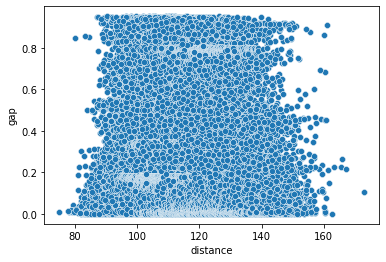

In [158]:
sns.scatterplot(x=df['distance'], y=df['gap'])